In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
with open('2011_09_26/2011_09_26_drive_0002_sync/velodyne_points/data/0000000000.bin', 'rb') as f:
    data =f.read()

In [3]:
points = np.fromfile('2011_09_26/2011_09_26_drive_0002_sync/velodyne_points/data/0000000000.bin', dtype=np.float32).reshape(-1, 4)

In [4]:
points

array([[51.587,  0.103,  1.954,  0.   ],
       [51.245,  0.183,  1.942,  0.   ],
       [51.26 ,  0.344,  1.942,  0.   ],
       ...,
       [ 3.704, -1.401, -1.731,  0.32 ],
       [ 3.737, -1.4  , -1.745,  0.42 ],
       [ 3.747, -1.39 , -1.748,  0.   ]], dtype=float32)

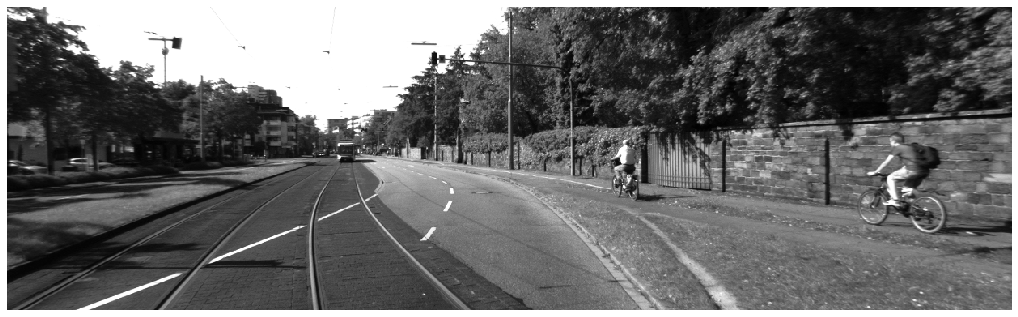

In [5]:
im = Image.open('2011_09_26/2011_09_26_drive_0002_sync/image_00/data/0000000000.png')
f = plt.figure(figsize=(18, 10))
plt.imshow(im, cmap=plt.cm.Greys_r)
plt.axis('off');

In [6]:
import time
import datetime as dt
import dateutil

In [7]:
class Velo2Cam:
    def __init__(self, file):
        self.file = file
        calib_time, R, T, delta_f, delta_c = open(file)
        self.calib_time = dateutil.parser.parse(calib_time[11:])
        self.R = np.fromstring(R[2:], dtype=np.float32, sep=' ').reshape((3, 3))
        self.t = np.fromstring(T[2:], dtype=np.float32, sep=' ').reshape((3, 1))
        self.df = np.fromstring(delta_f[9:], dtype=np.float32, sep=' ')
        self.dc = np.fromstring(delta_c[9:], dtype=np.float32, sep=' ')

In [8]:
v = Velo2Cam('2011_09_26/calib_velo_to_cam.txt')

In [9]:
v.R, v.t

(array([[ 7.533745e-03, -9.999714e-01, -6.166020e-04],
        [ 1.480249e-02,  7.280733e-04, -9.998902e-01],
        [ 9.998621e-01,  7.523790e-03,  1.480755e-02]], dtype=float32),
 array([[-0.00406977],
        [-0.07631618],
        [-0.2717806 ]], dtype=float32))

In [10]:
point_cam = points[...,:-1] @ v.R + v.t.squeeze()

In [11]:
class Cam:
    def __init__(self, id, S=None, K=None, D=None, R=None, T=None, S_rect=None, P_rect=None, R_rect=None):
        self.id = id
        self.S = S
        self.K = K
        self.D = D
        self.R = R
        self.T = T
        self.S_rect = S_rect
        self.R_rect = R_rect
        self.P_rect = P_rect
    
    def __repr__(self):
        return f'C[{self.id}]'

class Projection:
    def __init__(self, file):
        self.file = file
        with open(file) as f:
            lines = f.readlines()
        calib_time, corner_dist, *calibs = lines
        self.calib_time = dateutil.parser.parse(calib_time[11:])
        self.corner_dict = np.fromstring(corner_dist[12:], sep=' ', dtype=np.float32)
        self.cams = dict()
        cur_cam = None
        for line in calibs:
            tokens = line.split(" ")
            
            field = tokens[0]
            field, cam_id = field.rsplit("_", maxsplit=1)
            cam_id = cam_id.rstrip(":")
#             print("FIELD:", field, "CAM_ID:", cam_id)
            if cur_cam is None or cam_id != cur_cam.id:
                cur_cam = Cam(cam_id)
                self.cams[cam_id] = cur_cam
            
            parsed = np.fromstring(' '.join(tokens[1:]), dtype=np.float32, sep=' ')
            if field == 'S':
                cur_cam.S = parsed
            elif field == 'K':
                cur_cam.K = parsed
            elif field == 'D':
                cur_cam.D = parsed
            elif field == 'R':
                cur_cam.R = parsed.reshape((3, 3))
            elif field == 'T':
                cur_cam.T = parsed
            elif field == 'R_rect':
                cur_cam.R_rect = parsed.reshape((3, 3))
            elif field == 'P_rect':
                cur_cam.P_rect = parsed.reshape(3, 4)[:, :-1]
            elif field == 'S_rect':
                cur_cam.S_rect = parsed
            else:
                raise ValueError(f"Unrecognized field {field}")

In [12]:
pr = Projection('2011_09_26/calib_cam_to_cam.txt')

In [13]:
cam_coords = point_cam @ pr.cams['00'].P_rect

In [14]:
cam_coords

array([[  1688.2747, -37265.305 ,  -7501.5146],
       [  1678.6128, -37018.57  ,  -7450.649 ],
       [  1680.4138, -37029.31  ,  -7451.8604],
       ...,
       [ -1246.575 ,  -2737.6973,  -1707.8646],
       [ -1256.4851,  -2761.5828,  -1721.9602],
       [ -1258.4883,  -2768.809 ,  -1725.3937]], dtype=float32)

In [15]:
divided = cam_coords / cam_coords[:, 2][:, np.newaxis]

In [16]:
xy = divided[:, :2]

In [17]:
xy.min(axis=0), xy.mean(axis=0), xy.max(axis=0)

(array([-47520.73 , -25661.955], dtype=float32),
 array([-0.1018393,  4.5298223], dtype=float32),
 array([  7362.427, 166623.66 ], dtype=float32))

In [18]:
import cv2
cv2.__version__

'4.1.1'

In [19]:
img = im.copy()
img = cv2.imread('2011_09_26/2011_09_26_drive_0002_sync/image_00/data/0000000000.png')
for c in xy:
    img = cv2.circle(img, (np.int32(c[0]), np.int32(c[1])), 3, (255,0, 0), -1)

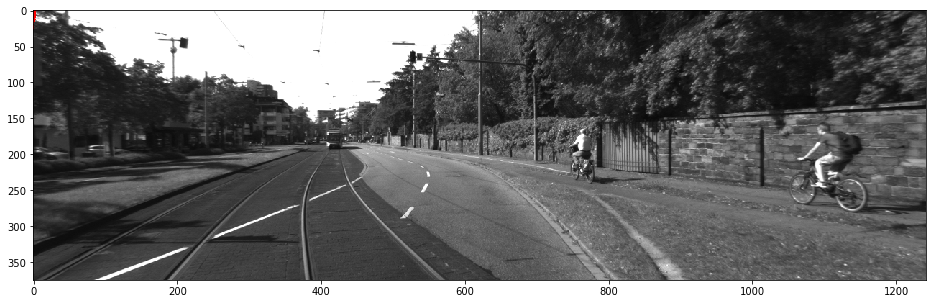

In [20]:
plt.figure(figsize=(16, 10))
plt.imshow(img);

In [33]:
RT_ = np.concatenate((v.R, v.t), axis=1)

In [34]:
cam_xyz = points[:, :-1].copy()
cam_homo = np.hstack((cam_xyz, np.ones((len(points), 1))))

In [35]:
cam_homo.shape, RT_.shape

((121080, 4), (3, 4))

In [39]:
# cam_xyz = cam_homo @ RT_
# cam_xyz.shape

In [40]:
pr.cams['00'].R_rect
cam = pr.cams['00']

In [41]:
def project(xyz, RT_, P_):
    for i in range(xyz.shape[1]):
            xyz[:3,i] = np.matmul(RT_, xyz[:,i])

    """
    xyz_c - 3D velodyne points corresponding to h, v FOV in the camera coordinates
             [x_1 , x_2 , .. ]
    xyz_c =  [y_1 , y_2 , .. ]   
             [z_1 , z_2 , .. ]
    """ 
    xyz_c = np.delete(xyz, 3, axis=0)

    # convert camera coordinates(X_c, Y_c, Z_c) image(pixel) coordinates(x,y) 
    for i in range(xyz_c.shape[1]):
        xyz_c[:,i] = np.matmul(P_, xyz_c[:,i])    

    """
    xy_i - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates before scale adjustment
    ans  - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates
             [s_1*x_1 , s_2*x_2 , .. ]
    xy_i =   [s_1*y_1 , s_2*y_2 , .. ]        ans =   [x_1 , x_2 , .. ]  
             [  s_1   ,   s_2   , .. ]                [y_1 , y_2 , .. ]
    """
    xy_i = xyz_c[::]/xyz_c[::][2]
    ans = np.delete(xy_i, 2, axis=0)
    return ans

In [42]:
xyz = points[:,:-1]

In [43]:
xyz = np.vstack((xyz.T, np.ones((xyz.shape[0], 1)).T))

In [44]:
projected = project(xyz, RT_, cam.P_rect)

In [53]:
color = np.sqrt(xyz[0, :].astype(float) ** 2 + xyz[1, :].astype(float) ** 2 + xyz[2, :].astype(float) ** 2)

In [54]:
color

array([51.35419796, 51.01221602, 51.02804121, ...,  4.05968514,
        4.09297297,  4.09926755])

In [46]:
projected = projected.T

In [47]:
def depth_color(val, min_d=0, max_d=120):
    """ 
    print Color(HSV's H value) corresponding to distance(m) 
    close distance = red , far distance = blue
    """
    np.clip(val, 0, max_d, out=val) # max distance is 120m but usually not usual
    return (((val - min_d) / (max_d - min_d)) * max_d).astype(np.uint8) 

In [48]:
color = depth_color(points[:, -1])

In [49]:
points[:, -1]

array([0.  , 0.  , 0.  , ..., 0.32, 0.42, 0.  ], dtype=float32)

In [50]:
img = im.copy()
img = cv2.imread('2011_09_26/2011_09_26_drive_0002_sync/image_00/data/0000000000.png')
for i,c in enumerate(projected):
    img = cv2.circle(img, (np.int32(c[0]), np.int32(c[1])), 1, (int(points[i, -1] * 255),0, 0), -1)

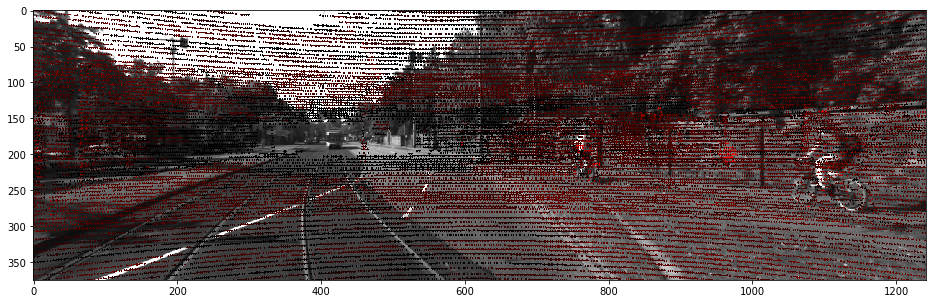

In [51]:
plt.figure(figsize=(16, 10))
plt.imshow(img);